# Outlier Detection based on Nonlinear Principal Component Analysis

## Introduction

The goal of this example usage is to discriminate time histories from undamaged and damaged condition based on outlier detection. The first four statistical moments are used as damage-sensitive features and a machine learning algorithm based on nonlinear principal component analysis (NLPCA) is used to create damage indicators (DIs) invariant for feature vectors from normal structural condition and that increase when feature vectors are from damaged structural conditions.

Data sets from Channel 5 of the 3-story structure are used in this example usage. More details about the data sets can be found in the 3-Story Data Sets documentation.

Requires TensorFlow library and data3ss.mat dataset.

### References:

- Figueiredo, E., Park, G., Figueiras, J., Farrar, C., & Worden, K. (2009). Structural Health Monitoring Algorithm Comparisons using Standard Data Sets. Los Alamos National Laboratory Report: LA-14393.

- Sohn, H., Worden, K., & Farrar, C. R. (2002). Statistical Damage Classification under Changing Environmental and Operational Conditions. Journal of Intelligent Material Systems and Structures, 13 (9), 561-574.

- Kramer, M. A. (1991). Nonlinear Principal Component Analysis using Autoassociative Neural Networks. AIChE Journal, 37 (2), 233-243.

### SHMTools functions used:

- `stat_moments_shm`
- `learn_nlpca_shm`
- `score_nlpca_shm`

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add shmtools to path
notebook_dir = Path.cwd()
possible_paths = [
    notebook_dir.parent.parent.parent,  # From examples/notebooks/advanced/
    notebook_dir.parent.parent,         # From examples/notebooks/
    notebook_dir,                       # From project root
]

for path in possible_paths:
    shmtools_path = path / 'shmtools'
    if shmtools_path.exists() and shmtools_path.is_dir():
        if str(path) not in sys.path:
            sys.path.insert(0, str(path))
        print(f"Found shmtools at: {path}")
        break
else:
    print("Warning: Could not find shmtools directory")

# Import SHM functions
from shmtools.utils.data_loading import load_3story_data
from shmtools.core.statistics import stat_moments_shm

try:
    from shmtools.classification.nlpca import learn_nlpca_shm, score_nlpca_shm
    print("NLPCA functions imported successfully")
except ImportError as e:
    print(f"Warning: NLPCA functions not available. Error: {e}")
    print("Please install TensorFlow: pip install tensorflow")

Found shmtools at: /Users/eric/repo/shm/shmtools-python


NLPCA functions imported successfully


## Load Raw Data

Load data set composed of acceleration time histories:

In [2]:
# Load the 3-story structure dataset
data = load_3story_data()
dataset = data['dataset']  # Shape: (8192, 5, 170)
print(f"Dataset shape: {dataset.shape}")
print(f"Time points: {dataset.shape[0]}")
print(f"Channels: {dataset.shape[1]}")
print(f"Conditions: {dataset.shape[2]}")

Dataset shape: (8192, 5, 170)
Time points: 8192
Channels: 5
Conditions: 170


Plot one acceleration time history (Channel 5) from four state conditions:

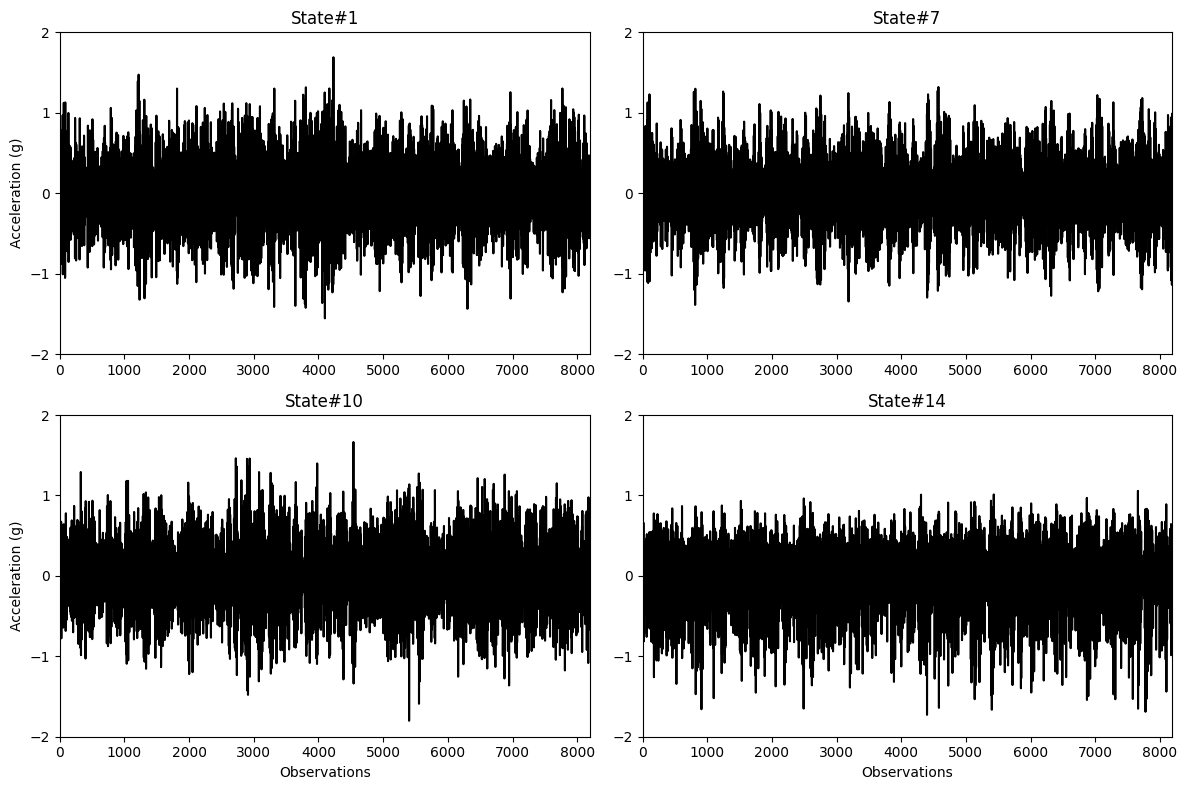

In [3]:
# Select states to plot (convert from MATLAB 1-based to Python 0-based indexing)
states = [0, 6, 9, 13]  # MATLAB states [1, 7, 10, 14] - 1
state_labels = [1, 7, 10, 14]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(4):
    # Use last test from each state (test 10, index 9)
    data_idx = states[i] * 10 + 9  # MATLAB: states(i)*10
    signal = dataset[:, 4, data_idx]  # Channel 5 (index 4), test condition
    
    axes[i].plot(signal, 'k')
    axes[i].set_title(f'State#{state_labels[i]}')
    axes[i].set_xlim([0, 8192])
    axes[i].set_ylim([-2, 2])
    axes[i].set_yticks(np.arange(-2, 3, 1))
    
    if i >= 2:  # Bottom row
        axes[i].set_xlabel('Observations')
    if i % 2 == 0:  # Left column
        axes[i].set_ylabel('Acceleration (g)')

plt.tight_layout()
plt.show()

## Extraction of Damage-Sensitive Features

The first four statistical moments (mean, standard deviation, skewness and kurtosis) are extracted from each time history and stored into a feature vector. Note that the data for the training process is not used later in the test process.

Estimation of the statistical moments:

In [4]:
# Extract statistical moments from Channel 5 only
channel_5_data = dataset[:, 4:5, :]  # Keep as 3D: (time, 1 channel, instances)
stat_moments = stat_moments_shm(channel_5_data)
print(f"Statistical moments shape: {stat_moments.shape}")
print(f"Features per channel: {stat_moments.shape[1]} (mean, std, skew, kurt)")
print(f"Instances: {stat_moments.shape[0]}")

Statistical moments shape: (170, 4)
Features per channel: 4 (mean, std, skew, kurt)
Instances: 170


Training data (undamaged feature vectors):

In [5]:
# Training data: 9 tests from each of 9 undamaged states (total 81 samples)
learn_data = []
for i in range(9):  # States 1-9 (undamaged)
    # Get tests 1-9 from each state (indices 0-8)
    start_idx = i * 10  # Start of state i+1
    end_idx = start_idx + 9  # First 9 tests from state i+1
    learn_data.append(stat_moments[start_idx:end_idx, :])

learn_data = np.vstack(learn_data)
print(f"Training data shape: {learn_data.shape}")
print(f"Training samples: {learn_data.shape[0]} (9 states × 9 tests)")

Training data shape: (81, 4)
Training samples: 81 (9 states × 9 tests)


Test data (9 undamaged and 8 damaged feature vectors):

In [6]:
# Test data: 10th test from each of the 17 states
score_data = []
for i in range(17):  # All 17 states
    test_idx = i * 10 + 9  # 10th test (index 9) from state i+1
    score_data.append(stat_moments[test_idx, :])

score_data = np.array(score_data)
n, m = score_data.shape
print(f"Test data shape: {score_data.shape}")
print(f"Test samples: {n} (9 undamaged + 8 damaged)")
print(f"Features per sample: {m}")

Test data shape: (17, 4)
Test samples: 17 (9 undamaged + 8 damaged)
Features per sample: 4


Plot test data:

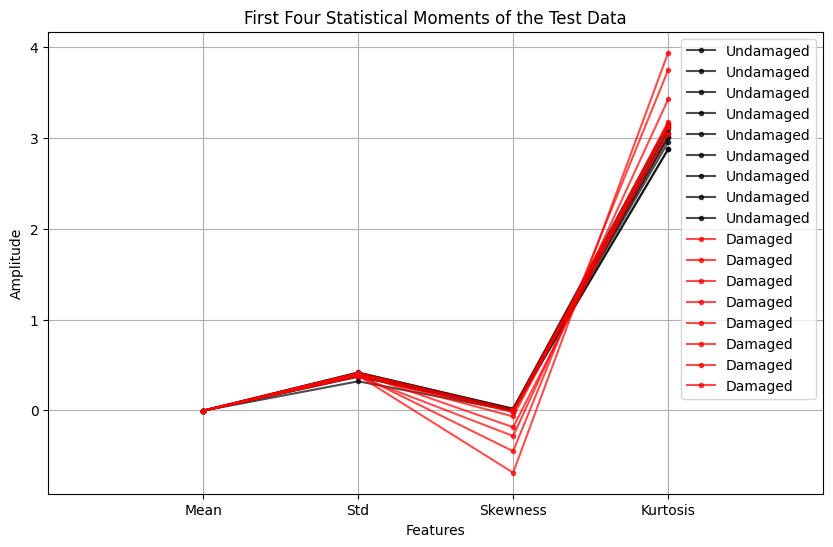

In [7]:
# Plot test data features
labels = ['Mean', 'Std', 'Skewness', 'Kurtosis']

plt.figure(figsize=(10, 6))

# Plot undamaged (first 9) and damaged (last 8) separately
x_pos = np.arange(1, m + 1)
plt.plot(x_pos, score_data[:9, :].T, '.-k', label='Undamaged', alpha=0.7)
plt.plot(x_pos, score_data[9:, :].T, '.-r', label='Damaged', alpha=0.7)

plt.title('First Four Statistical Moments of the Test Data')
plt.xlabel('Features')
plt.ylabel('Amplitude')
plt.xticks(x_pos, labels)
plt.xlim([0, 5])
plt.legend()
plt.grid(True)
plt.show()

## Statistical Modeling for Feature Classification

The NLPCA-based machine learning algorithm is used to create DIs invariant under feature vectors from the undamaged structural condition. The two nodes at the bottleneck layer represent the changes in mass and stiffness. Four nodes are assumed in both mapping layers.

Training:

In [8]:
# Train NLPCA model
# Parameters: 2 bottleneck nodes, 4 nodes in mapping layers
try:
    model = learn_nlpca_shm(learn_data, b=2, M1=4, M2=4)
    print(f"NLPCA model trained successfully")
    print(f"Training MSE: {model['E']:.6f}")
    print(f"Architecture: {learn_data.shape[1]} -> {model['M1']} -> {model['b']} -> {model['M2']} -> {learn_data.shape[1]}")
except Exception as e:
    print(f"Error training NLPCA model: {e}")
    raise

/Users/eric/repo/shm/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NLPCA model trained successfully
Training MSE: 0.632449
Architecture: 4 -> 4 -> 2 -> 4 -> 4


Scoring:

In [9]:
# Score test data
try:
    DI, residuals = score_nlpca_shm(score_data, model)
    print(f"Test data scored successfully")
    print(f"Damage indicators shape: {DI.shape}")
    print(f"Residuals shape: {residuals.shape}")
    print(f"DI range: {np.min(DI):.3f} to {np.max(DI):.3f}")
except Exception as e:
    print(f"Error scoring test data: {e}")
    raise

Test data scored successfully
Damage indicators shape: (17,)
Residuals shape: (17, 4)
DI range: -1.164 to -0.015


## Plot Damage Indicators

Threshold based on the 95% cut-off over the training data:

In [10]:
# Calculate threshold using training data
threshold_scores, _ = score_nlpca_shm(learn_data, model)
threshold_sorted = np.sort(-threshold_scores)  # Sort negative scores (MATLAB style)
UCL = threshold_sorted[int(len(threshold_sorted) * 0.95)]  # 95% percentile

print(f"Threshold (UCL): {UCL:.3f}")
print(f"Training scores range: {np.min(-threshold_scores):.3f} to {np.max(-threshold_scores):.3f}")

Threshold (UCL): 0.197
Training scores range: 0.014 to 0.236


Plot DIs:

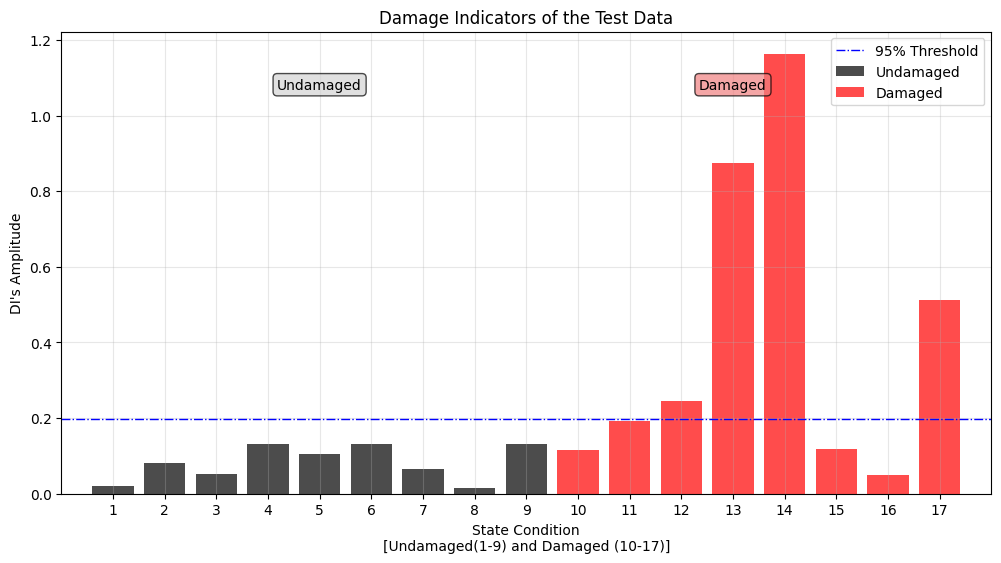

In [11]:
# Plot damage indicators
plt.figure(figsize=(12, 6))

# Plot undamaged (states 1-9) and damaged (states 10-17)
x_pos = np.arange(1, n + 1)
plt.bar(x_pos[:9], -DI[:9], color='k', label='Undamaged', alpha=0.7)
plt.bar(x_pos[9:], -DI[9:], color='r', label='Damaged', alpha=0.7)

# Add threshold line
plt.axhline(y=UCL, color='b', linestyle='-.', linewidth=1, label='95% Threshold')

plt.title('Damage Indicators of the Test Data')
plt.xlabel('State Condition\n[Undamaged(1-9) and Damaged (10-17)]')
plt.ylabel("DI's Amplitude")
plt.xlim([0, n + 1])
plt.xticks(x_pos, [f'{i}' for i in range(1, n + 1)])
plt.legend()
plt.grid(True, alpha=0.3)

# Add text annotations for clarity
plt.text(5, plt.ylim()[1] * 0.9, 'Undamaged', ha='center', va='top', 
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
plt.text(13, plt.ylim()[1] * 0.9, 'Damaged', ha='center', va='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.show()

## Performance Analysis

In [12]:
# Analyze classification performance
# Convert DI to damage classification (above threshold = damaged)
damage_predictions = (-DI) > UCL
true_labels = np.concatenate([np.zeros(9), np.ones(8)])  # 9 undamaged, 8 damaged

# Calculate confusion matrix elements
true_positives = np.sum((damage_predictions == 1) & (true_labels == 1))  # Correctly identified damage
true_negatives = np.sum((damage_predictions == 0) & (true_labels == 0))  # Correctly identified undamaged
false_positives = np.sum((damage_predictions == 1) & (true_labels == 0))  # False alarms
false_negatives = np.sum((damage_predictions == 0) & (true_labels == 1))  # Missed damage

# Calculate performance metrics
accuracy = (true_positives + true_negatives) / len(true_labels)
sensitivity = true_positives / np.sum(true_labels == 1) if np.sum(true_labels == 1) > 0 else 0
specificity = true_negatives / np.sum(true_labels == 0) if np.sum(true_labels == 0) > 0 else 0

print("Classification Performance:")
print(f"Accuracy: {accuracy:.1%}")
print(f"Sensitivity (damage detection rate): {sensitivity:.1%}")
print(f"Specificity (undamaged correct rate): {specificity:.1%}")
print(f"")
print(f"Confusion Matrix:")
print(f"True Positives (damage detected):  {true_positives}")
print(f"True Negatives (undamaged correct): {true_negatives}")
print(f"False Positives (false alarms):     {false_positives}")
print(f"False Negatives (missed damage):    {false_negatives}")

# Show individual classifications
print(f"\nIndividual Classifications:")
for i in range(len(DI)):
    state_type = "Undamaged" if i < 9 else "Damaged"
    prediction = "DAMAGED" if damage_predictions[i] else "Undamaged"
    correct = "✓" if damage_predictions[i] == true_labels[i] else "✗"
    print(f"State {i+1:2d} ({state_type:9s}): DI = {-DI[i]:6.3f}, Predicted: {prediction:9s} {correct}")

Classification Performance:
Accuracy: 76.5%
Sensitivity (damage detection rate): 50.0%
Specificity (undamaged correct rate): 100.0%

Confusion Matrix:
True Positives (damage detected):  4
True Negatives (undamaged correct): 9
False Positives (false alarms):     0
False Negatives (missed damage):    4

Individual Classifications:
State  1 (Undamaged): DI =  0.019, Predicted: Undamaged ✓
State  2 (Undamaged): DI =  0.080, Predicted: Undamaged ✓
State  3 (Undamaged): DI =  0.052, Predicted: Undamaged ✓
State  4 (Undamaged): DI =  0.131, Predicted: Undamaged ✓
State  5 (Undamaged): DI =  0.106, Predicted: Undamaged ✓
State  6 (Undamaged): DI =  0.132, Predicted: Undamaged ✓
State  7 (Undamaged): DI =  0.065, Predicted: Undamaged ✓
State  8 (Undamaged): DI =  0.015, Predicted: Undamaged ✓
State  9 (Undamaged): DI =  0.132, Predicted: Undamaged ✓
State 10 (Damaged  ): DI =  0.115, Predicted: Undamaged ✗
State 11 (Damaged  ): DI =  0.193, Predicted: Undamaged ✗
State 12 (Damaged  ): DI =  0.2

## Summary

This example demonstrates the use of Nonlinear Principal Component Analysis (NLPCA) for outlier detection in structural health monitoring. The NLPCA autoencoder neural network:

1. **Learns nonlinear correlations** among statistical moment features from undamaged structural conditions
2. **Uses a bottleneck layer** to represent underlying damage mechanisms (mass/stiffness changes)
3. **Produces damage indicators** based on reconstruction errors that increase with damage

### Key Results:
- The NLPCA model successfully discriminates between undamaged and damaged structural states
- Statistical moments (mean, std, skewness, kurtosis) provide effective damage-sensitive features
- The nonlinear approach can capture complex relationships that linear methods might miss

### Note:
The performance of this algorithm can be improved by changing the architecture of the network, such as by increasing the number of nodes in the mapping layers or adjusting the bottleneck size based on the expected number of damage mechanisms.

### See also:
- Outlier Detection Based on the Factor Analysis Model
- Outlier Detection Based on Principal Component Analysis
- Outlier Detection Based on the Singular Value Decomposition
- Outlier Detection Based on the Mahalanobis Distance